# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma
from src.optim import EvolutionnarySearch
import random

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [2]:
from src.policies.custom_linear_evol_policies import tuned_make_linear_incentive_function, tuned_make_linear_quota_function

scenario_0_best_ind = {
    "PF": 1.4342356535532237,
    "PG": 0.6662408429966779,
    "WF_EF": 0.5104268591566881,
    "PUR": 0.3402569495351941,
    "SUB_BC" : 1.9762293986536237,
    "FIN_BC" : 0.17021769764908726,
    "WF_SF": 8.126357459692112,
    "ANT_C_F": 0.4585625212587976,
    "ANT_N_F": 0.2716974474707285,
    "CF": 1.994113079871528,
    "CG": 0.2723421170311795
}

scenario_1_best_ind = {
    "PF":1.3714379827600525,
    "PG":7.154471999587505,
    "WF_EF":0.4214744283977393,
    "PUR":0.6755029716107883,
    "SUB_BC" :0.7860125188217294,
    "FIN_BC" : 0.11158330598535778,
    "WF_SF":7.700511187509747,
    "ANT_C_F":-0.1579986566700551,
    "ANT_N_F":0.6969863696527481,
    "CF":1.5100765416314796,
    "CG":0.5769929397796756
}

yaml_path = 'parameters/scenarios/1.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 500        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  # Uncertainty in forecasts
# Initialize and run simulation
base_simulation = wms.WaterManagementSimulation(**params)

N_GEN = 1

search = EvolutionnarySearch(
    simulation=base_simulation,
    p_best_parents=2,
    pop_size=100,
    n_gen=N_GEN,
    mutation_rate=0.8, # Only 40% of genes will mutate at each generation, the less it is, the more stable evolution will be
    initial_mutation_spread=1, # Mutation will follow a random mutation (increase or decrease) in a normally distributed factor centered around 1, with your desired standard deviation (the bigger it gets, the bigger changes will be)  
    ecol_weight=1.1, # Focus a bit more on ecological impact
    econ_weight=1,
)

# Faut encore modifier les fonctions en make fonction et créer l'intialiseur
search.make_incentive_function = MethodType(tuned_make_linear_incentive_function, search)
search.make_quota_function = MethodType(tuned_make_linear_quota_function, search)

scenario_0_incentive = search.make_incentive_function(scenario_0_best_ind)
scenario_1_incentive = search.make_incentive_function(scenario_1_best_ind)

scenario_0_quota = search.make_quota_function(scenario_0_best_ind)
scenario_1_quota = search.make_quota_function(scenario_1_best_ind)

In [3]:
def cumul_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:

    if DOE == .1 and DCR == .05:
    # if True:
     #     print("Using scenario_0_incentive")
         return scenario_0_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    else:
        #  print("Using scenario_1_incentive")
         return scenario_1_incentive(self,
                    actions,
                    actors_priority,
                    avg_incomes,
                    water_pump,
                    avg_pump,
                    is_crisis,
                    water_flows,
                    quota,
                    DOE,
                    DCR)
    

def cumul_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
    if DOE == .1 and DCR == .05:
    # if True:
         return scenario_0_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)
    else:
         return scenario_1_quota(self,
                    crisis_level,
                    actors_priority,
                    avg_pump,
                    DOE,
                    DCR)

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [4]:
if False:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=cumul_incentive_policy,
        custom_quota=cumul_quota)
    results_df.to_csv('results_cumul_linear_df.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('./multi_exec_results/results_cumul_linear_df.csv')


## Multi-Scenario Analysis


respectful_sim : 68
disrespectful_sim : 148


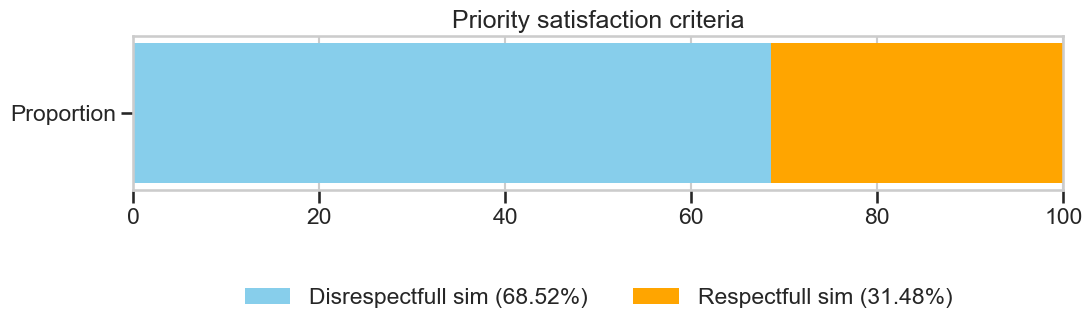

In [5]:
respectfull_sim = len(results_df[results_df["priority_ok"] == 1])
disrespectfull_sim = len(results_df[results_df["priority_ok"] == 0])
disrespectfull_proportion = round((disrespectfull_sim / (disrespectfull_sim + respectfull_sim)) * 100,2)
respectfull_proportion = round((respectfull_sim / (disrespectfull_sim + respectfull_sim)) * 100, 2)

print("respectful_sim :", respectfull_sim)
print("disrespectful_sim :", disrespectfull_sim)

fig, ax = plt.subplots(figsize=(12, 2))

# Affiche une barre horizontale avec deux segments empilés
ax.barh(y=["Proportion"], width=disrespectfull_proportion, color='skyblue', label=f"Disrespectfull sim ({disrespectfull_proportion}%)")
ax.barh(y=["Proportion"] , width=respectfull_proportion, left=disrespectfull_proportion, color='orange', label=f"Respectfull sim ({respectfull_proportion}%)")

# Ajout des labels
ax.set_xlim(0, 100)
ax.set_title("Priority satisfaction criteria")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=2)


plt.show()

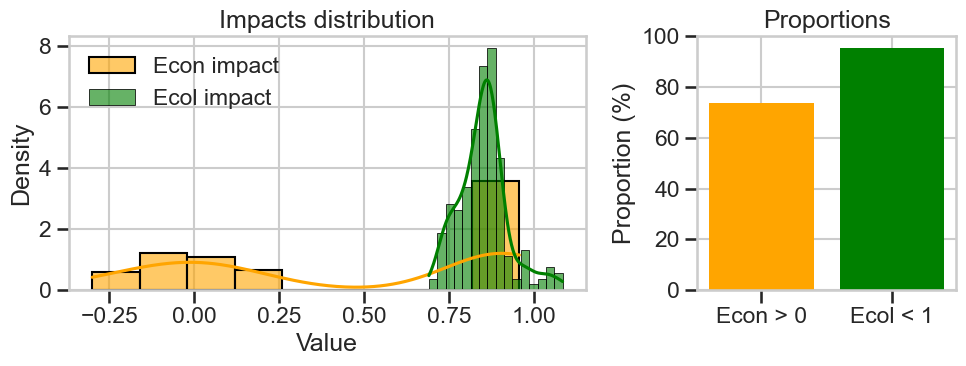

In [6]:
data_len = len(results_df)
sup_zero_econ_proportion = round((len(results_df[results_df["economic_impact"] > 0]) / data_len) * 100, 2)
sub_1_ecol_proportion = round((len(results_df[results_df["ecological_impact"] < 1]) / data_len) * 100, 2)

global_econ_impact_distrib = results_df["economic_impact"]
global_ecol_impact_distrib = results_df["ecological_impact"]


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Prépare la figure avec deux sous-graphiques côte à côte
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2:1 ratio

# 1. Graphique des distributions superposées
ax0 = plt.subplot(gs[0])
sns.histplot(global_econ_impact_distrib, kde=True, color="orange", label="Econ impact", ax=ax0, stat="density", alpha=0.6)
sns.histplot(global_ecol_impact_distrib, kde=True, color="green", label="Ecol impact", ax=ax0, stat="density", alpha=0.6)
ax0.set_title("Impacts distribution")
ax0.set_xlabel("Value")
ax0.legend()

# 2. Graphique en barres des proportions
ax1 = plt.subplot(gs[1])
ax1.bar(["Econ > 0", "Ecol < 1"], [sup_zero_econ_proportion, sub_1_ecol_proportion], color=["orange", "green"])
ax1.set_ylim(0, 100)
ax1.set_ylabel("Proportion (%)")
ax1.set_title("Proportions")

plt.tight_layout()
plt.show()


### Ecological vs. economic impact.

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


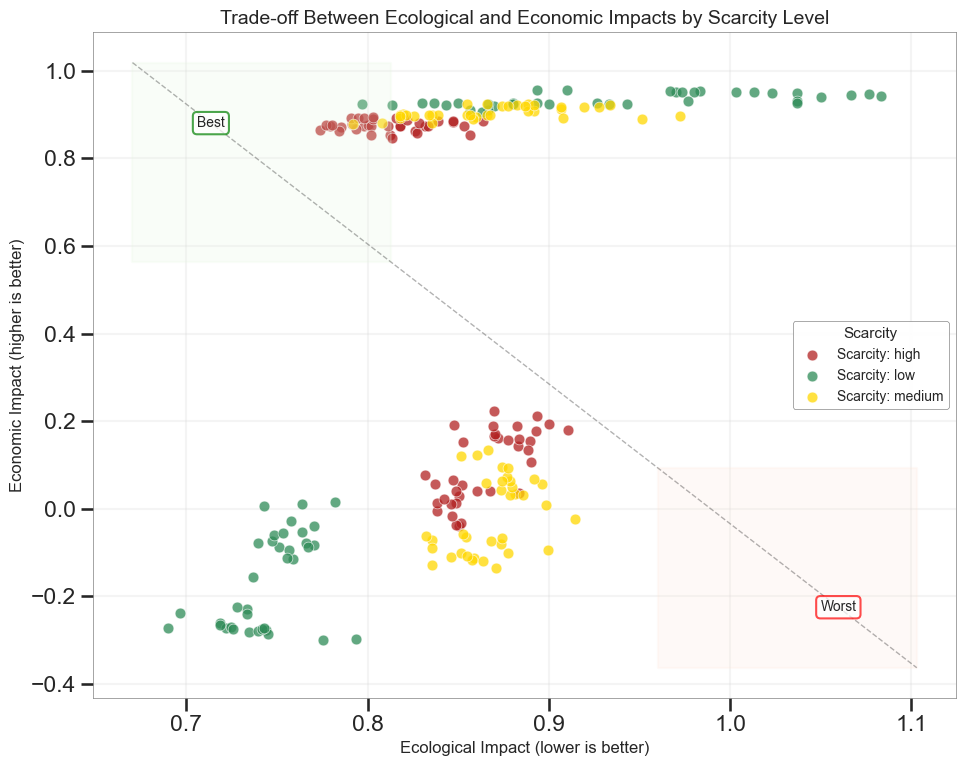

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


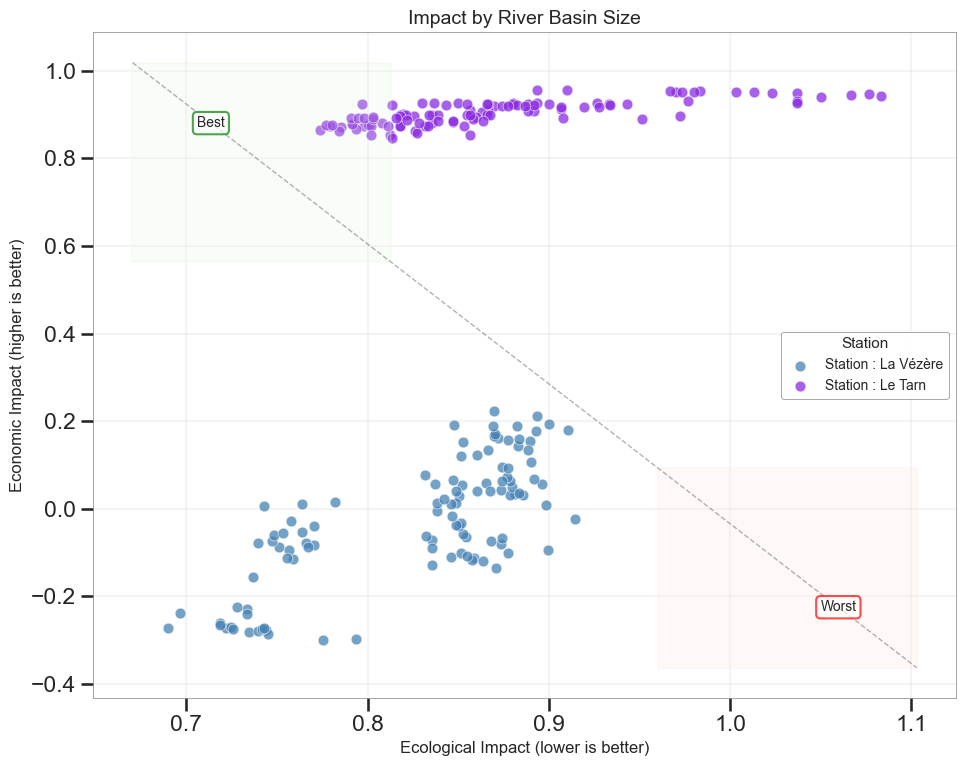

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


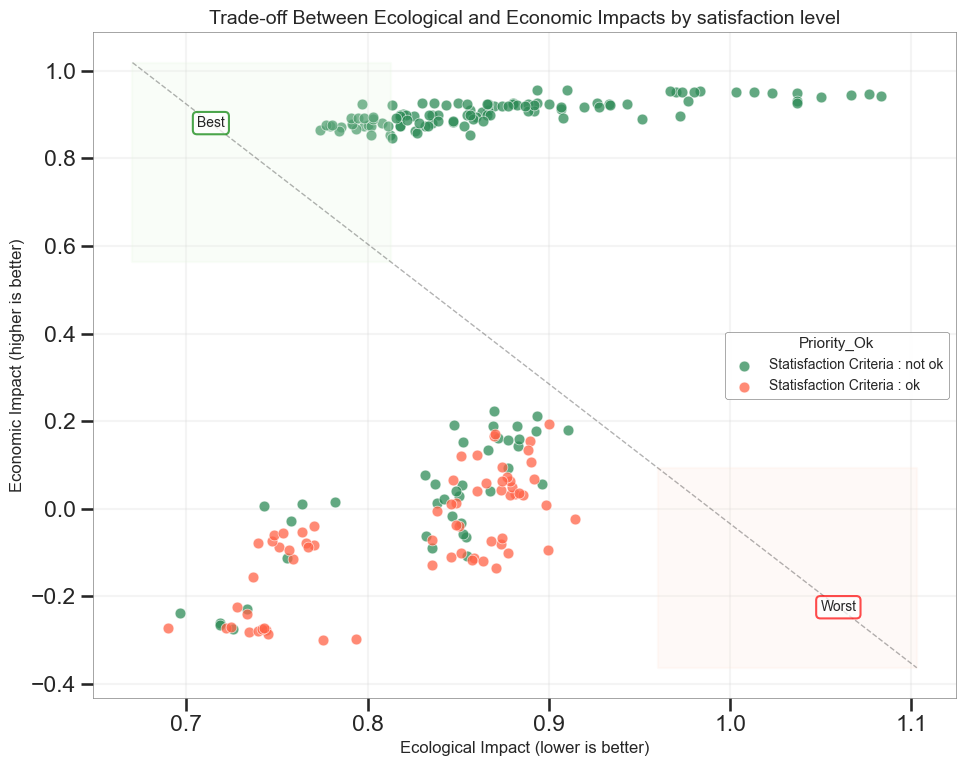

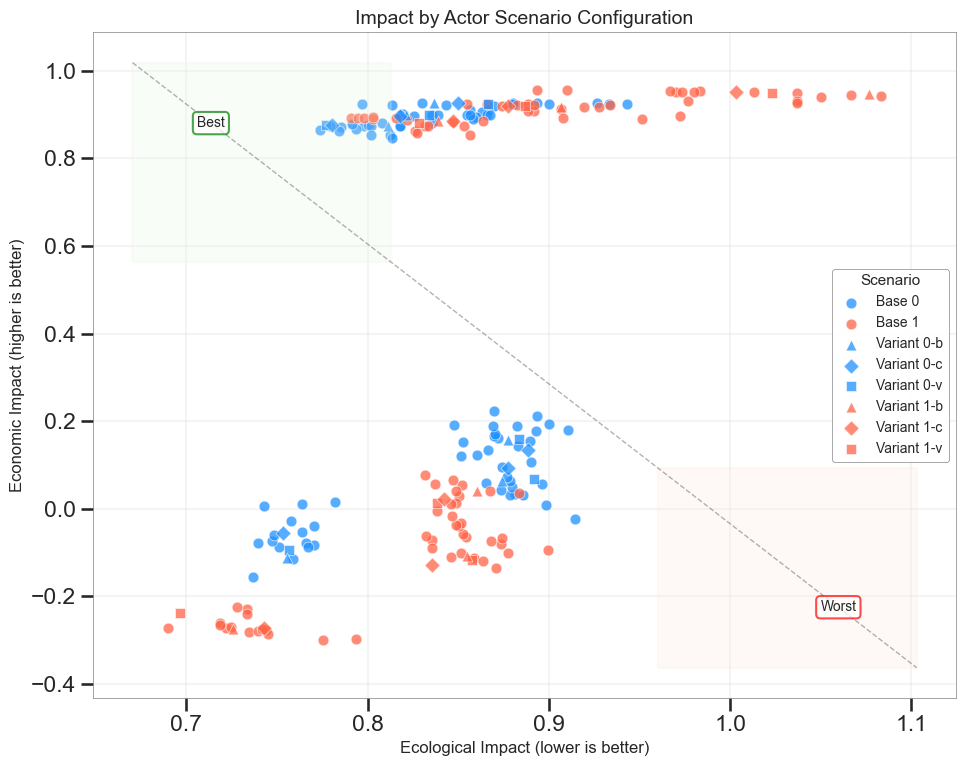

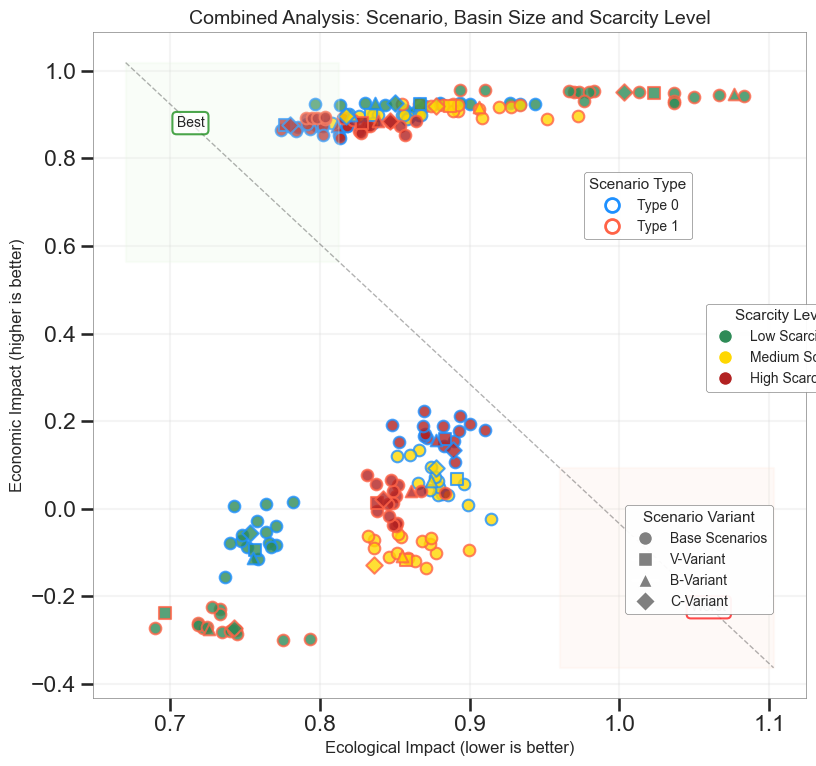

In [7]:
pma.analyze_scenario_impacts(results_df, is_scalled=True)

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


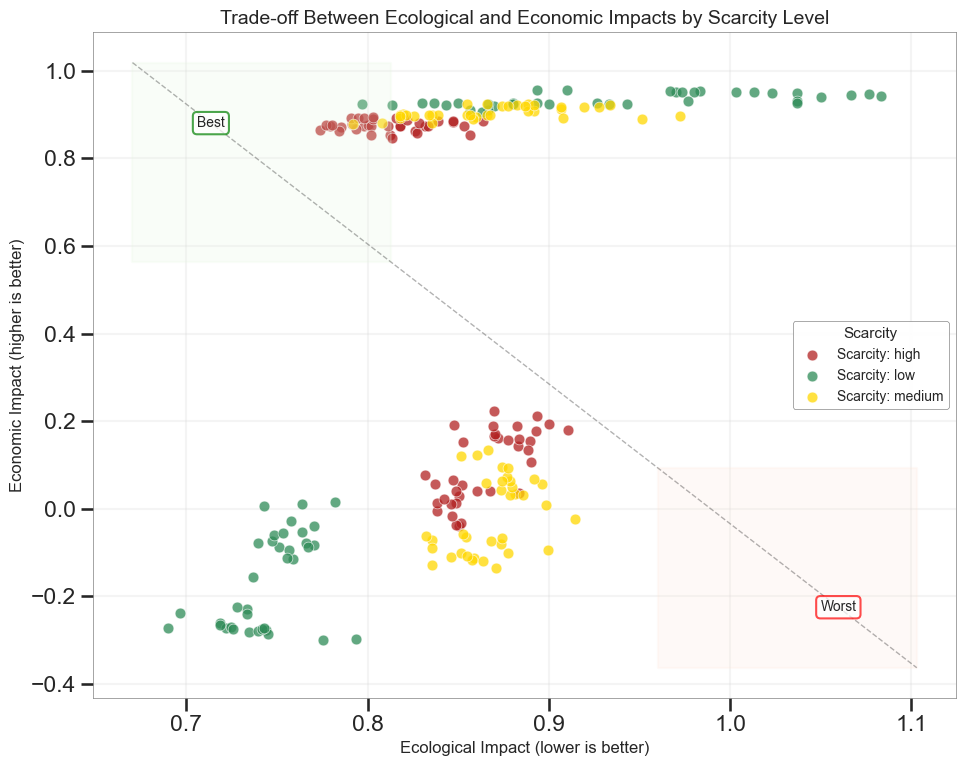

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


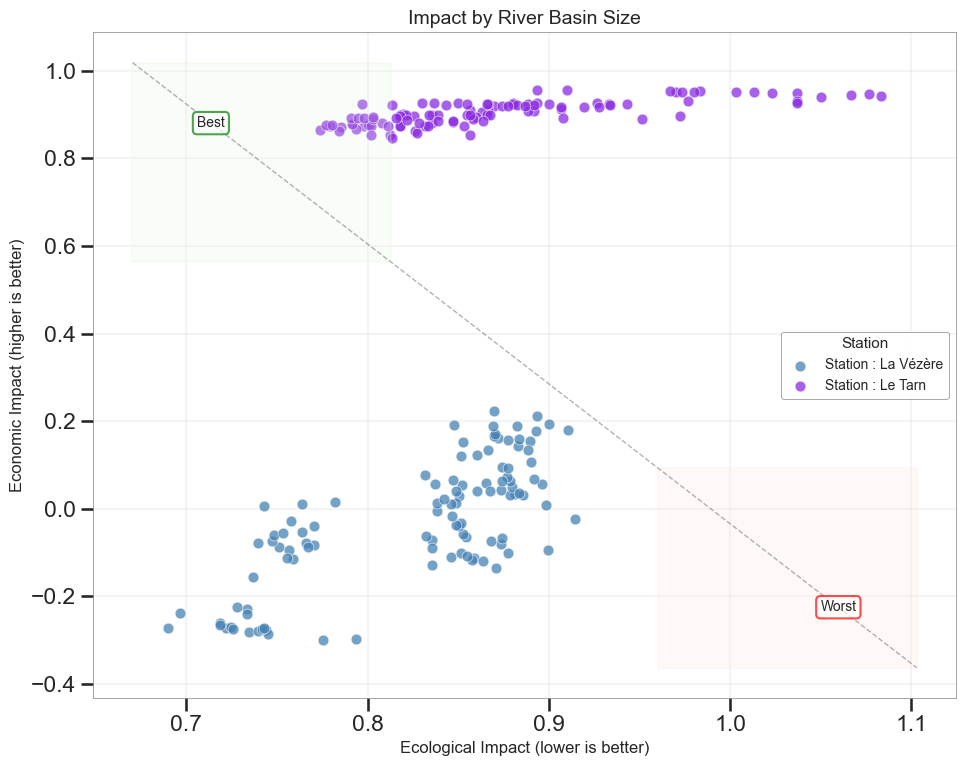

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


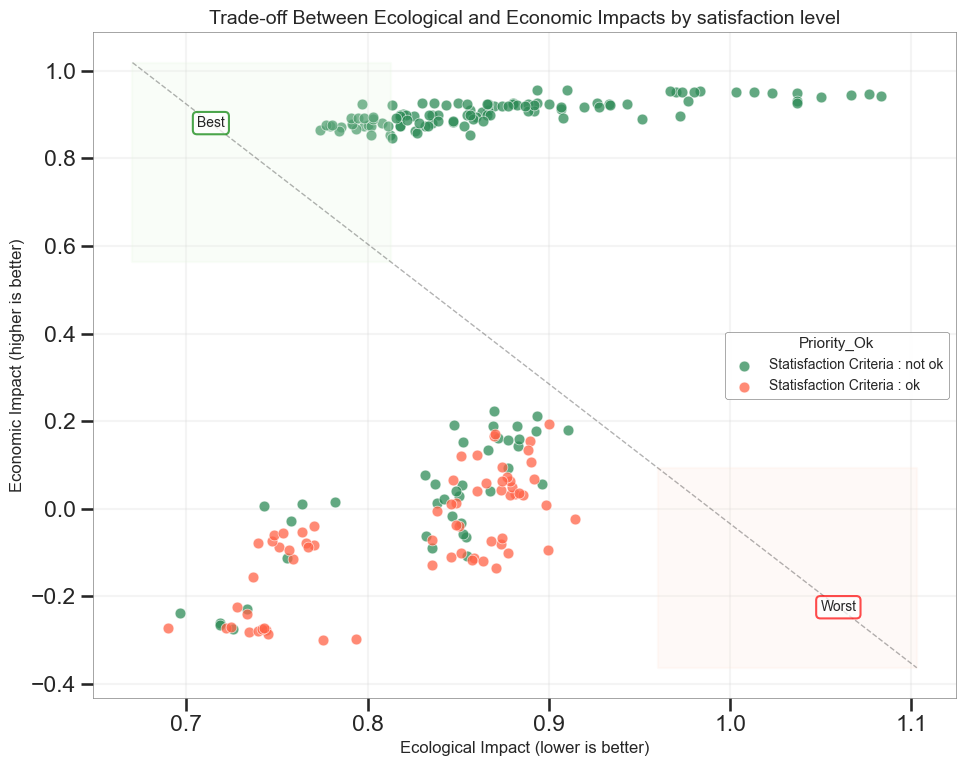

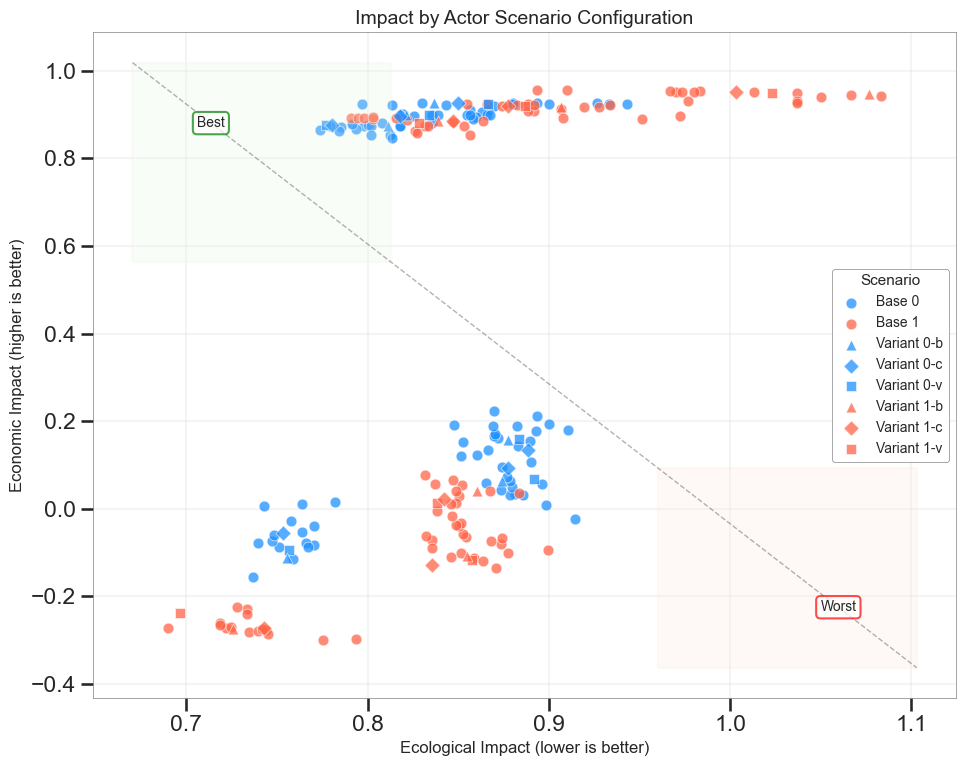

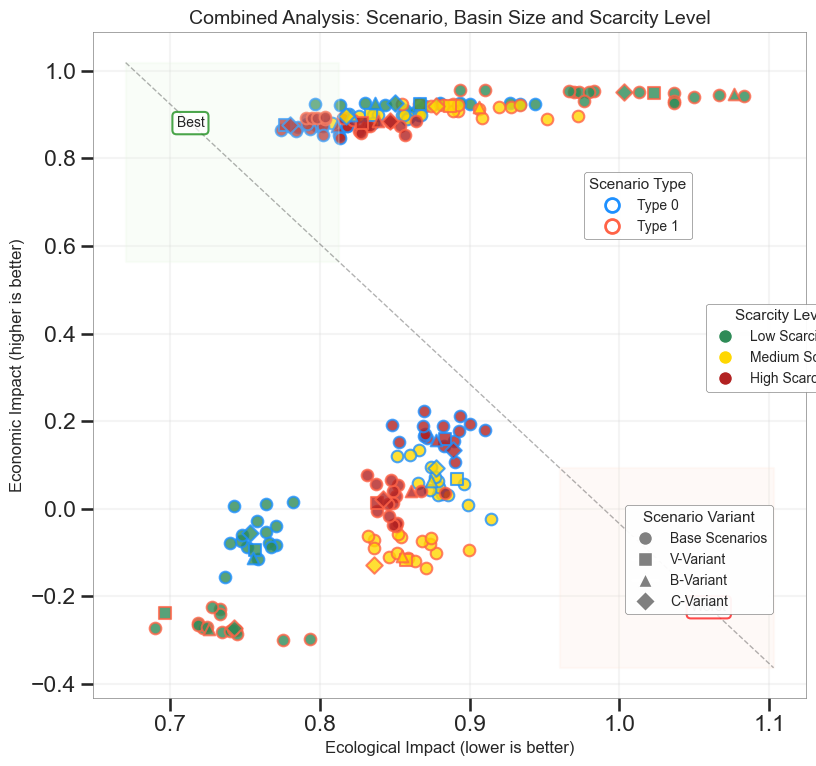

In [8]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

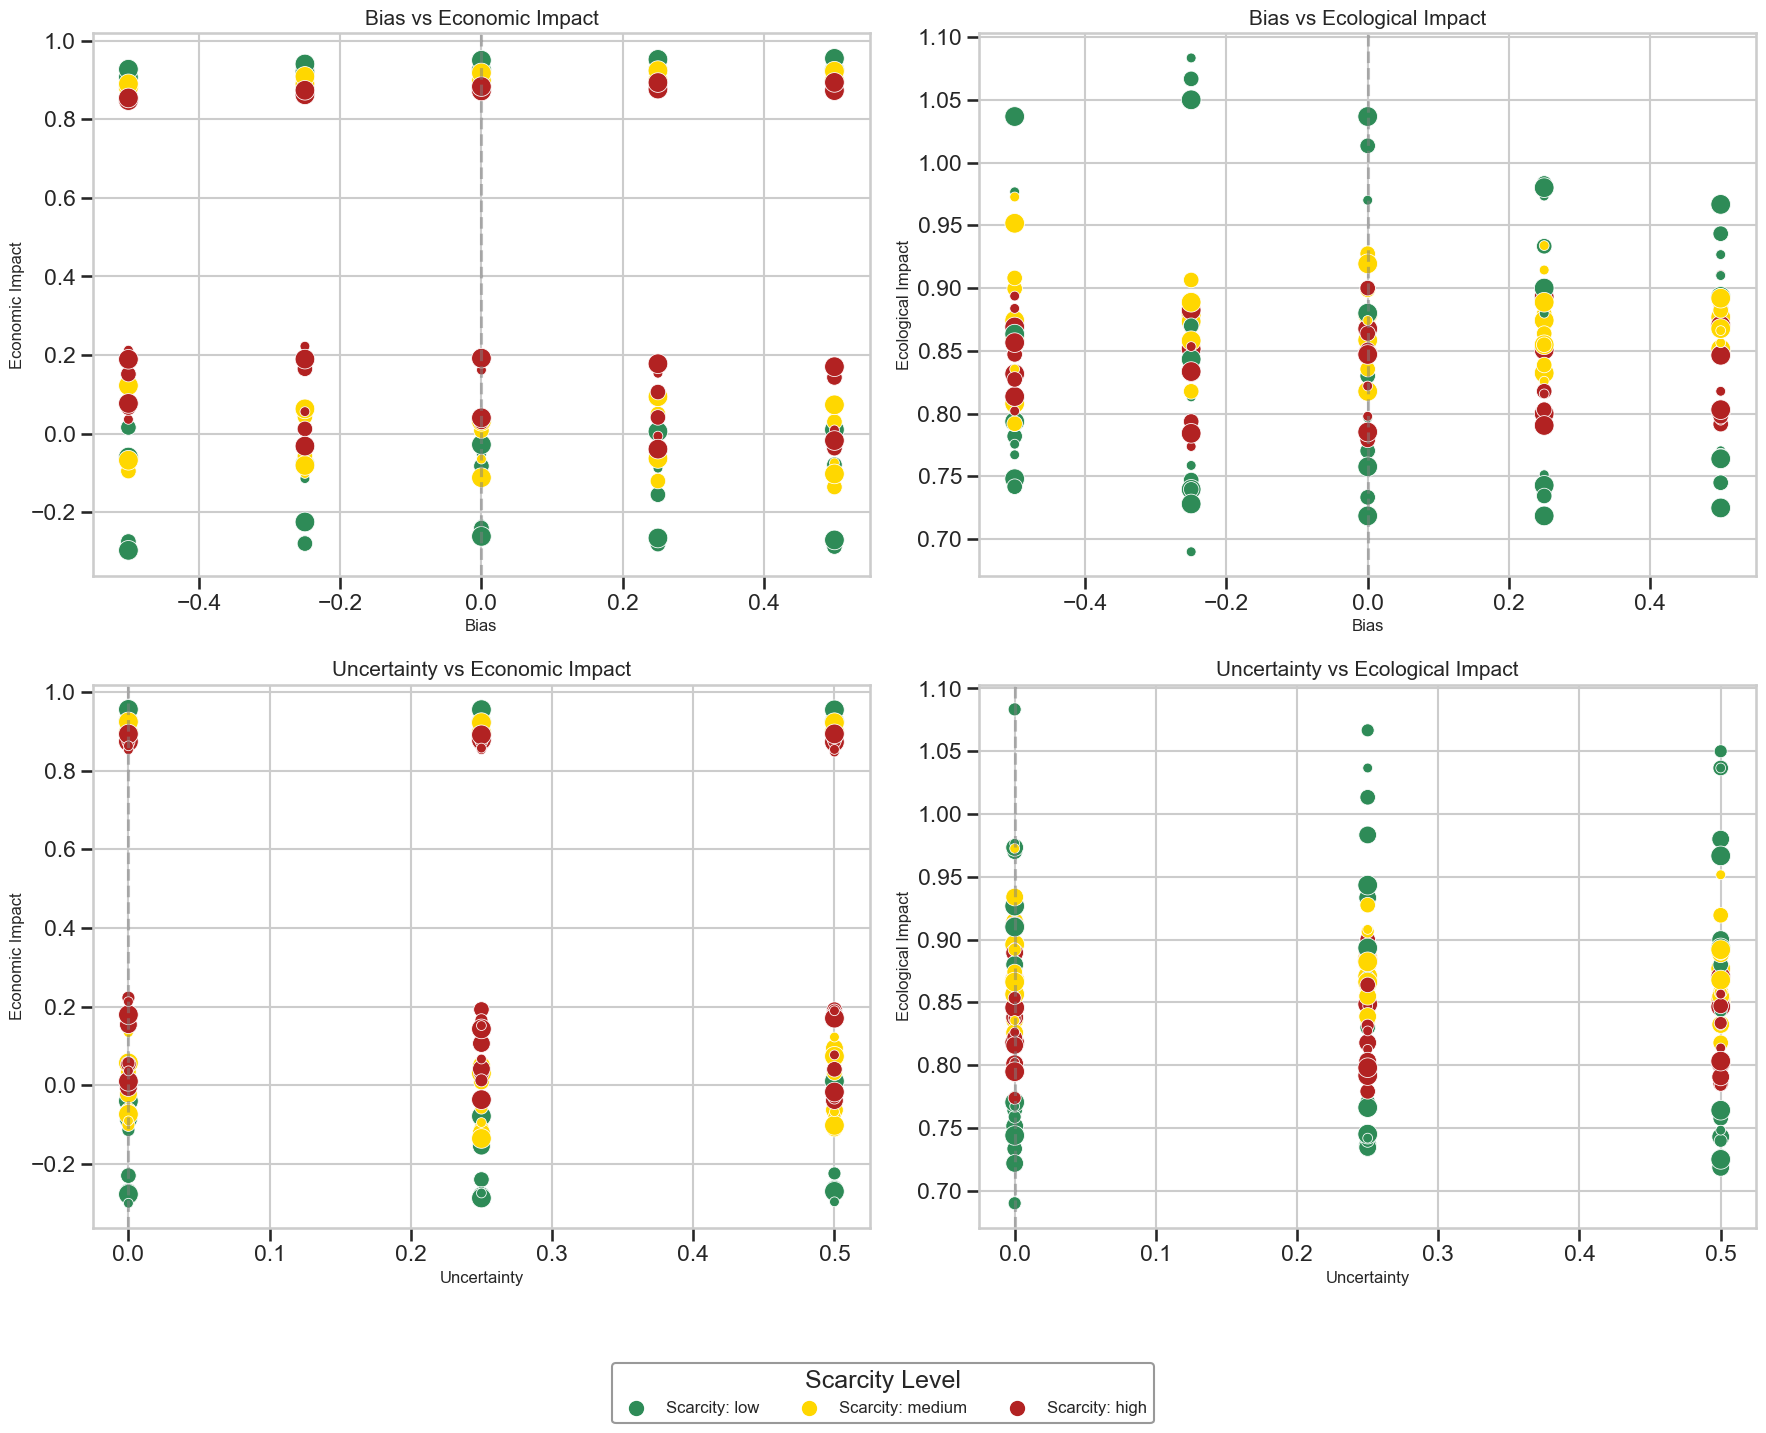

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


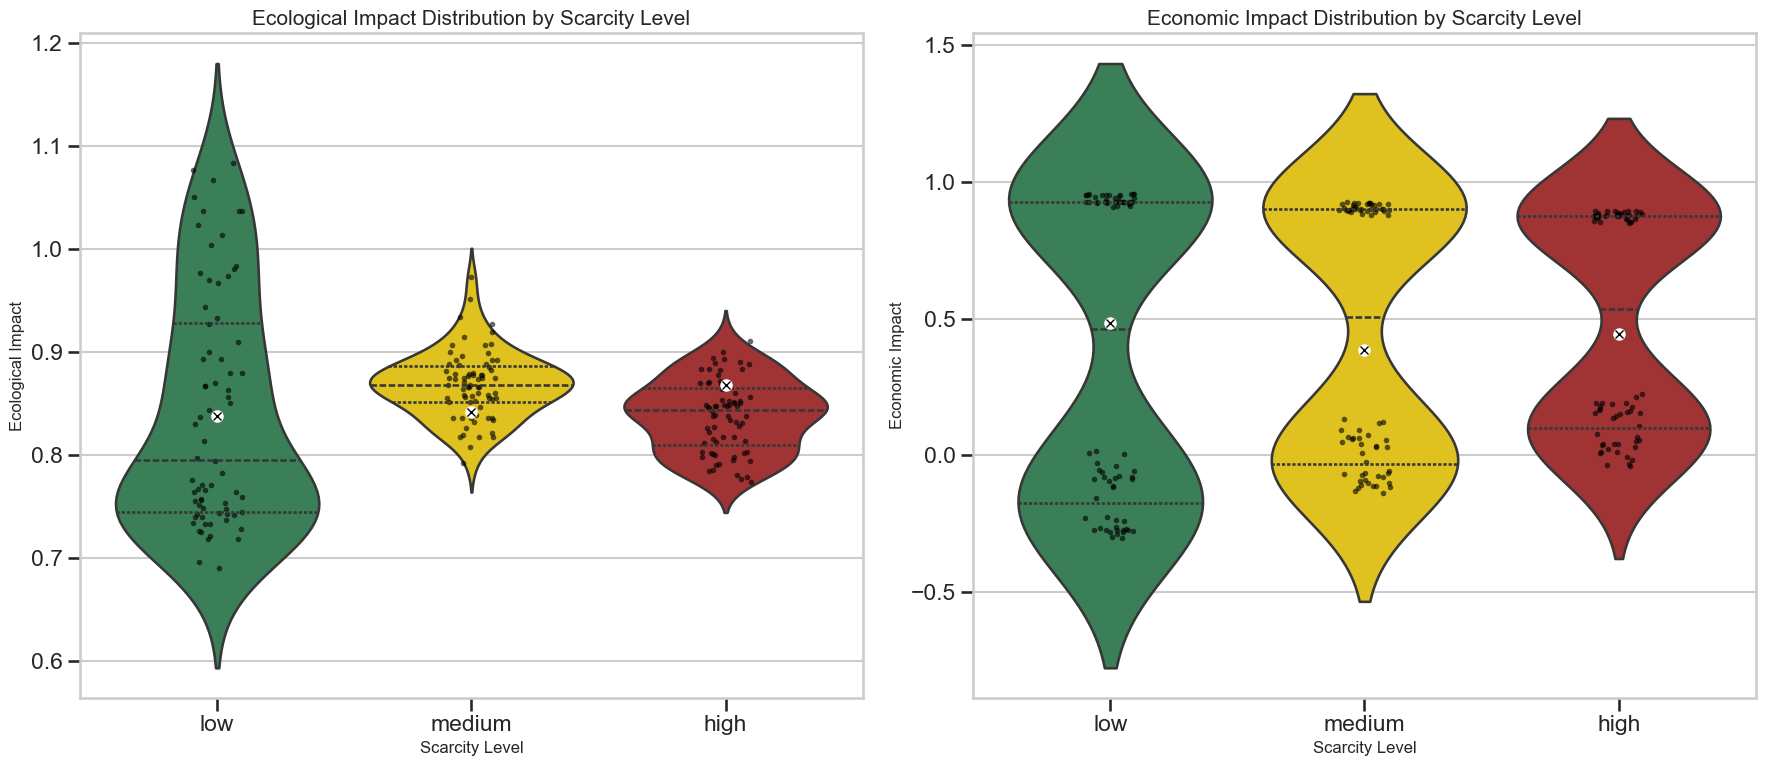

In [9]:
pma.analyze_forecast_effects(results_df, is_scalled=True)

## Correlation Analysis


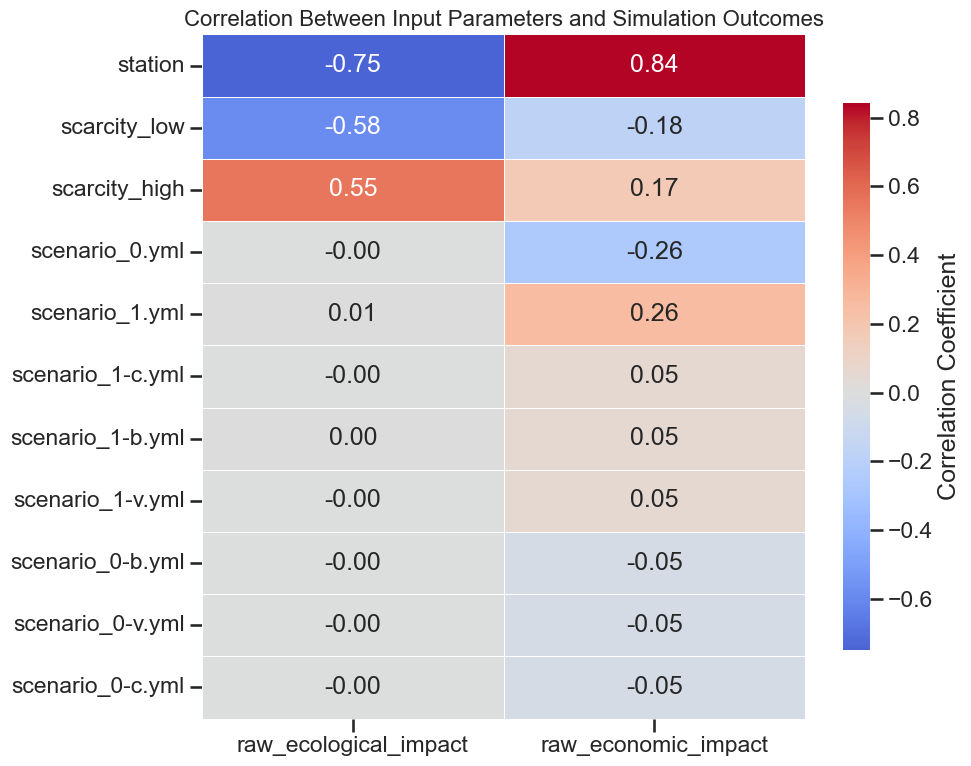


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  scarcity_high: 0.554
  scarcity_medium: 0.029
  scenario_1.yml: 0.006
  scenario_1-b.yml: 0.005
  uncertainty: -0.000

Top 5 negative correlations:
  scenario_0.yml: -0.003
  scenario_1-v.yml: -0.004
  bias: -0.004
  scarcity_low: -0.583
  station: -0.749

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  station: 0.843
  scenario_1.yml: 0.263
  scarcity_high: 0.173
  scenario_1-c.yml: 0.054
  scenario_1-b.yml: 0.053

Top 5 negative correlations:
  scenario_0-c.yml: -0.052
  scenario_0-v.yml: -0.052
  scenario_0-b.yml: -0.052
  scarcity_low: -0.179
  scenario_0.yml: -0.264


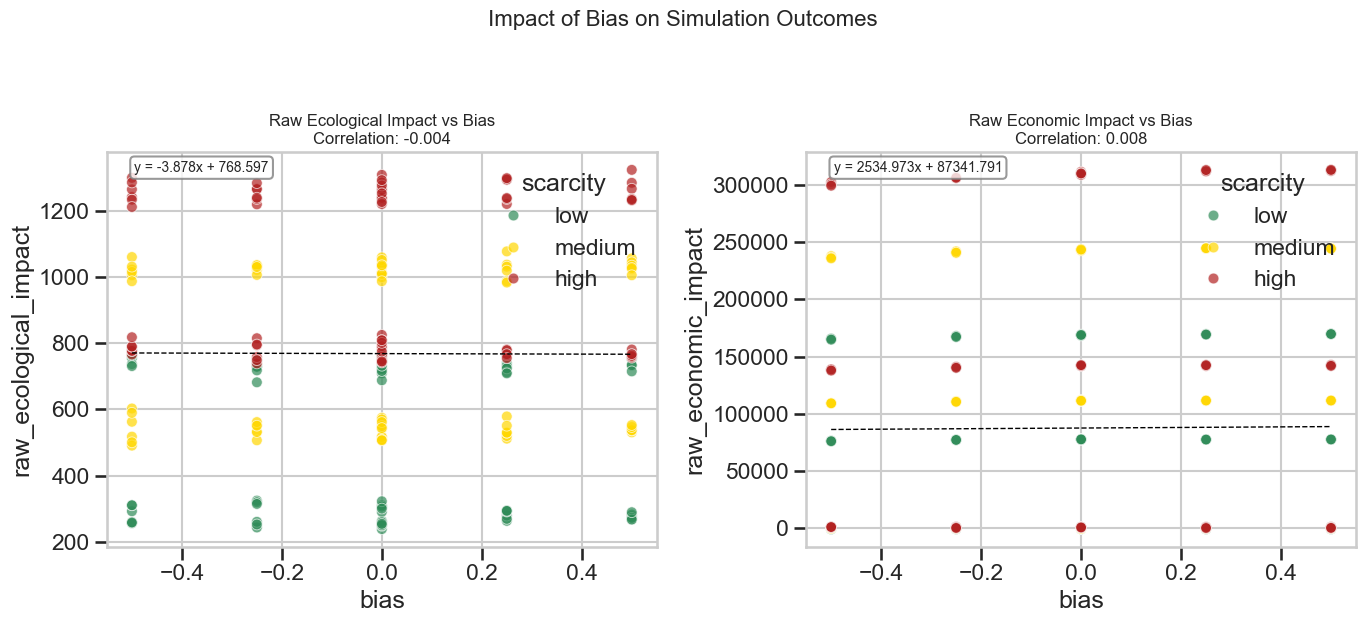

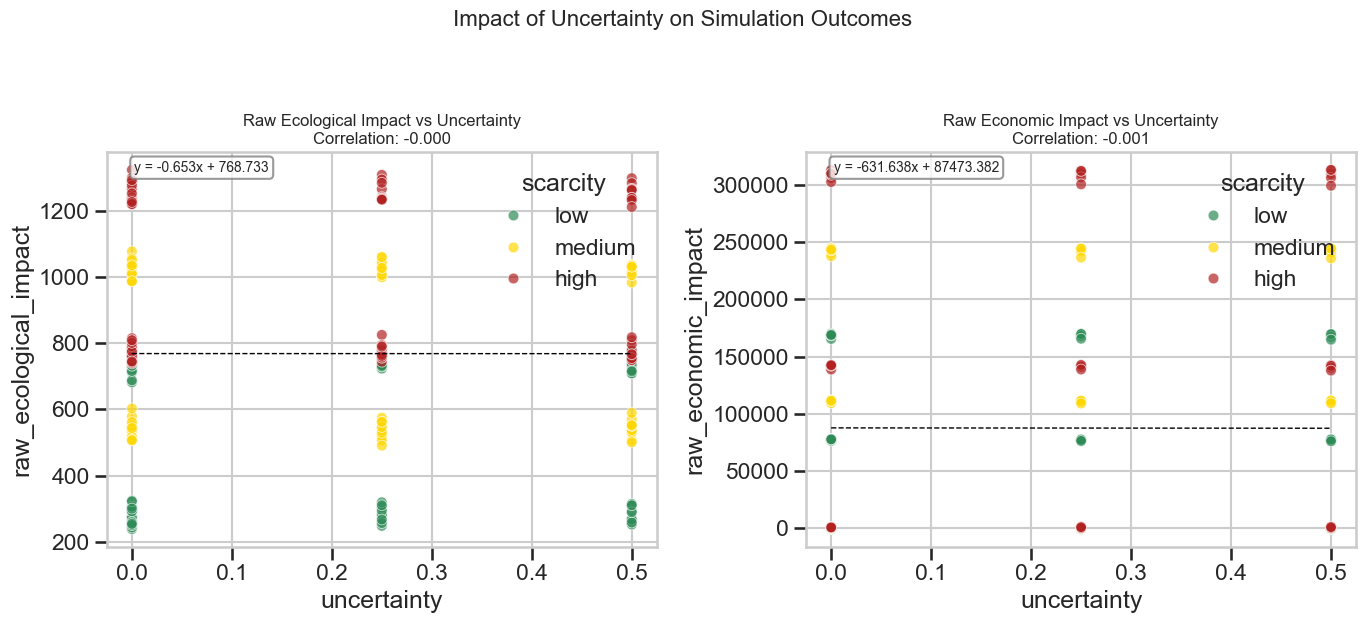

<Figure size 1200x1000 with 0 Axes>

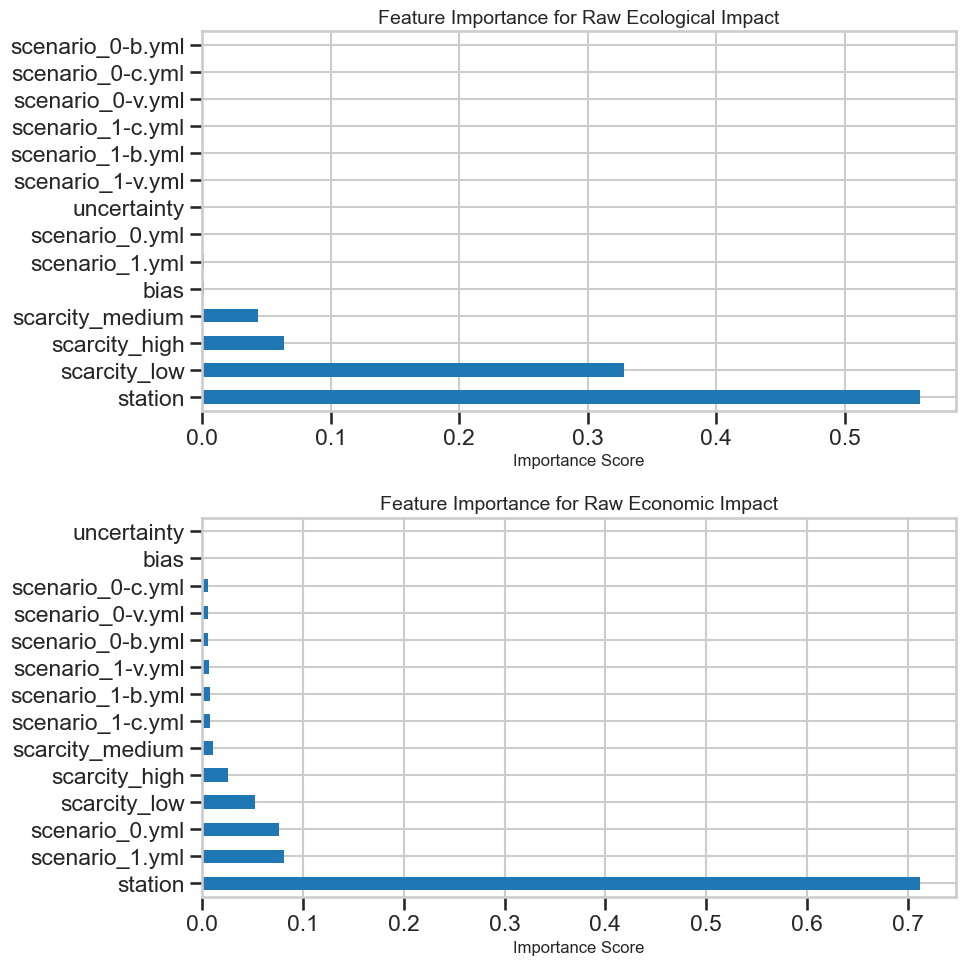

In [10]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:993: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


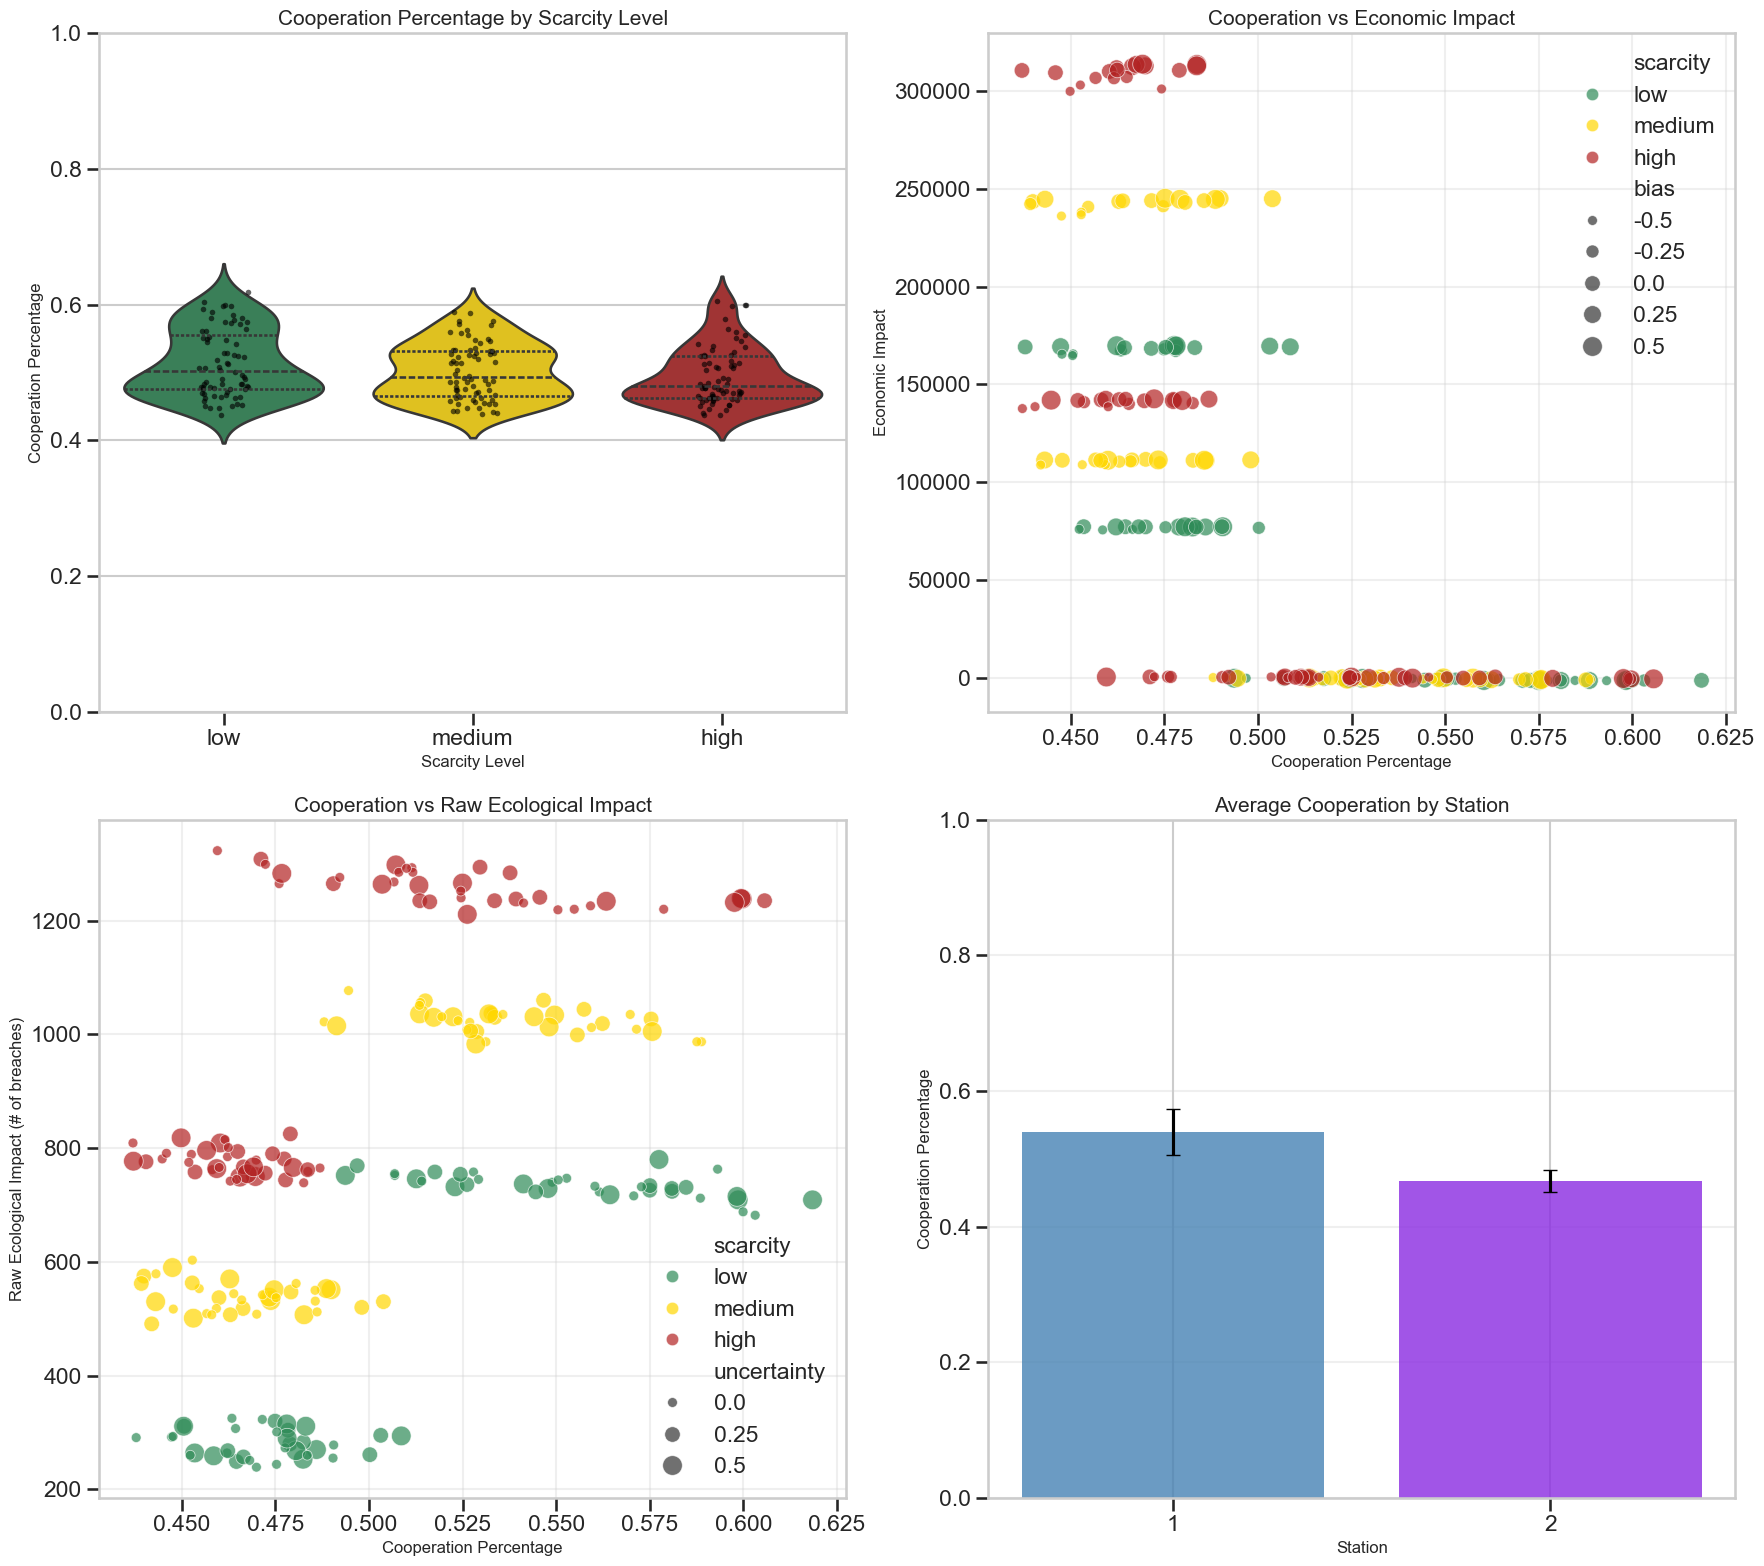

In [11]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

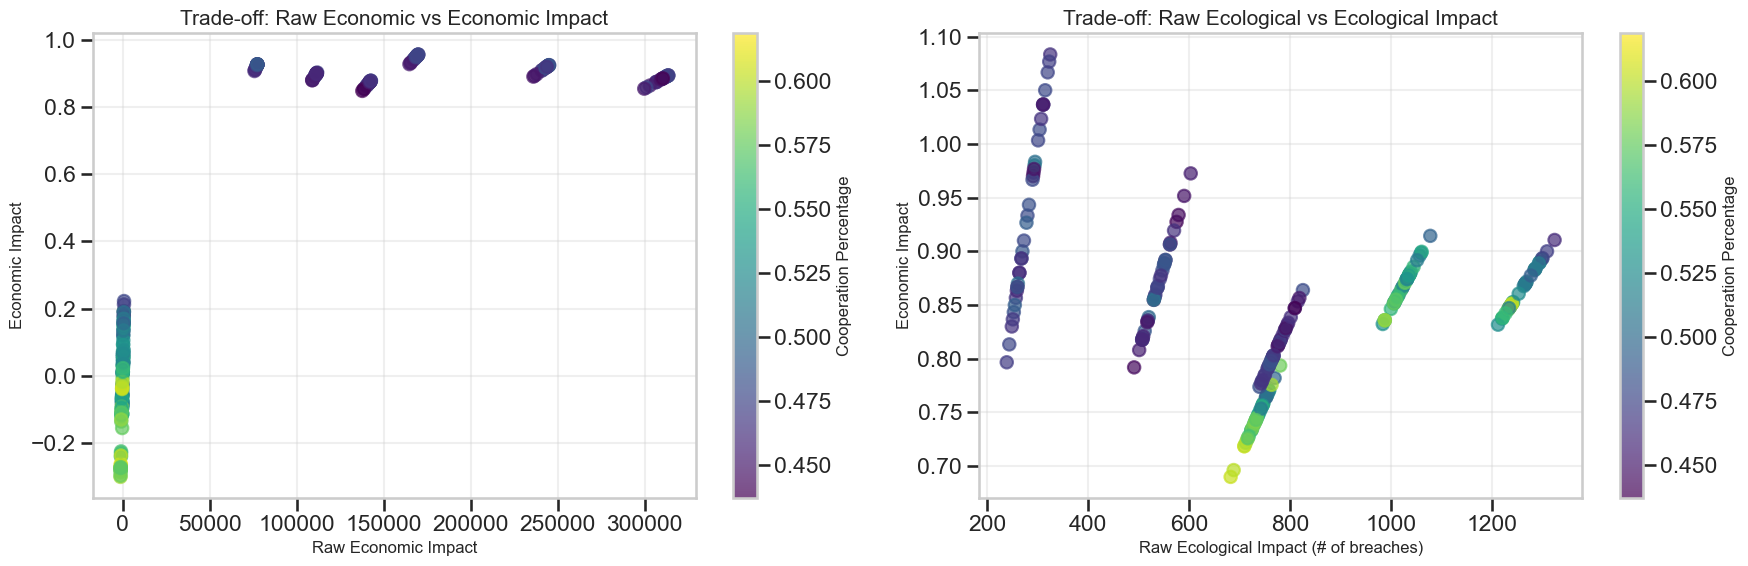

In [12]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


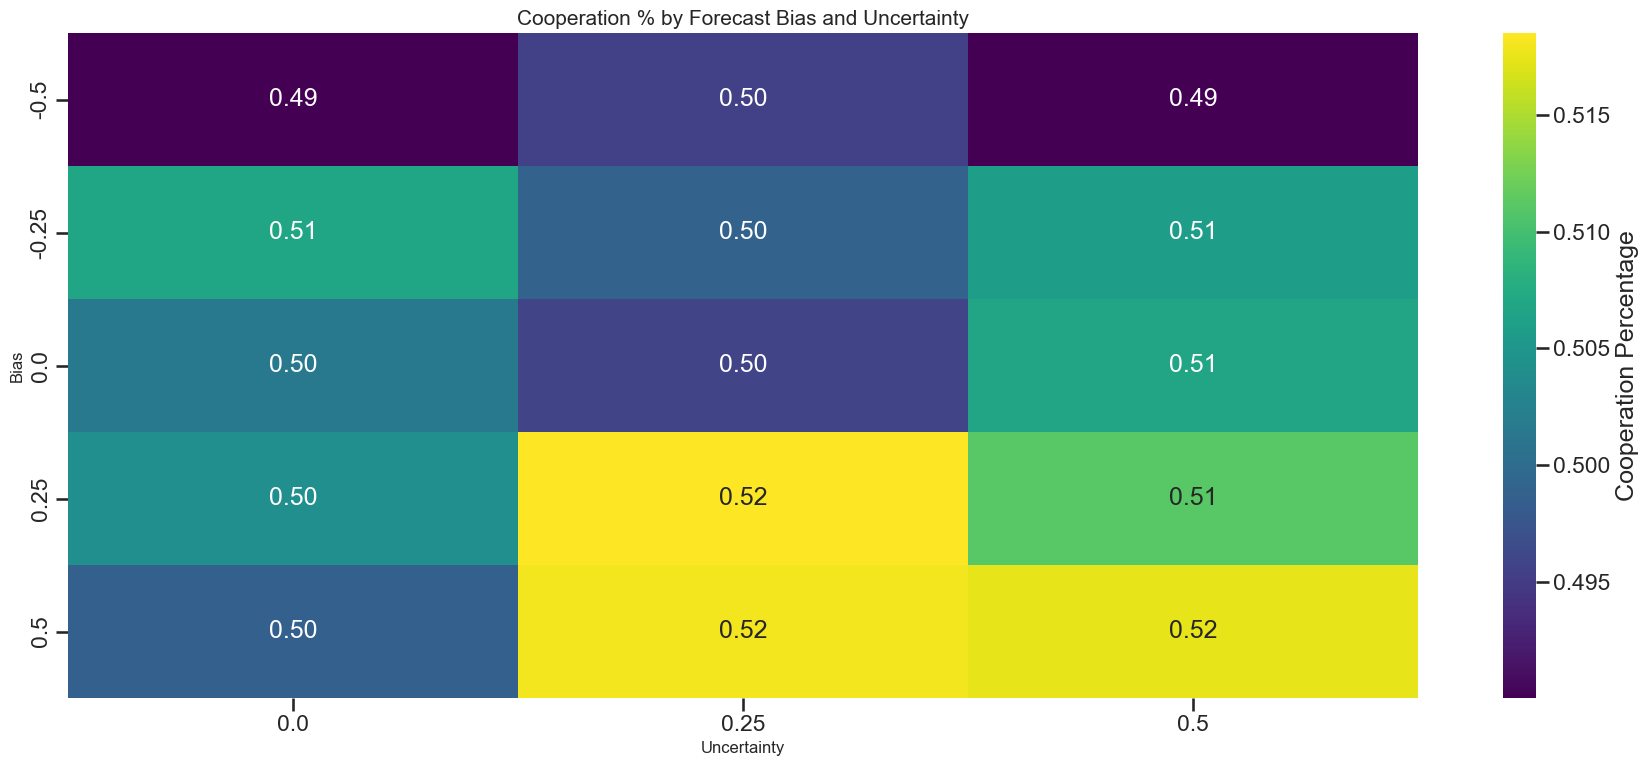

In [13]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.50
Average Raw Ecological Impact: 768.6 breaches
Average Scaled Ecological Impact: 0.849
Average Economic Impact: 87341.791

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.47   
raw_ecological_impact                     0.47                   1.00   
ecological_impact                        -0.40                  -0.19   
economic_impact                          -0.86                  -0.67   
raw_economic_impact                      -0.70                  -0.48   
bias                                      0.13                  -0.00   
uncertainty                               0.05                  -0.00   

                        ecological_impact  economic_impact  \
cooperation_percentage              -0.40            -0.86   
raw_ecological_impact               -0.19            -0.67   
ecological_impac

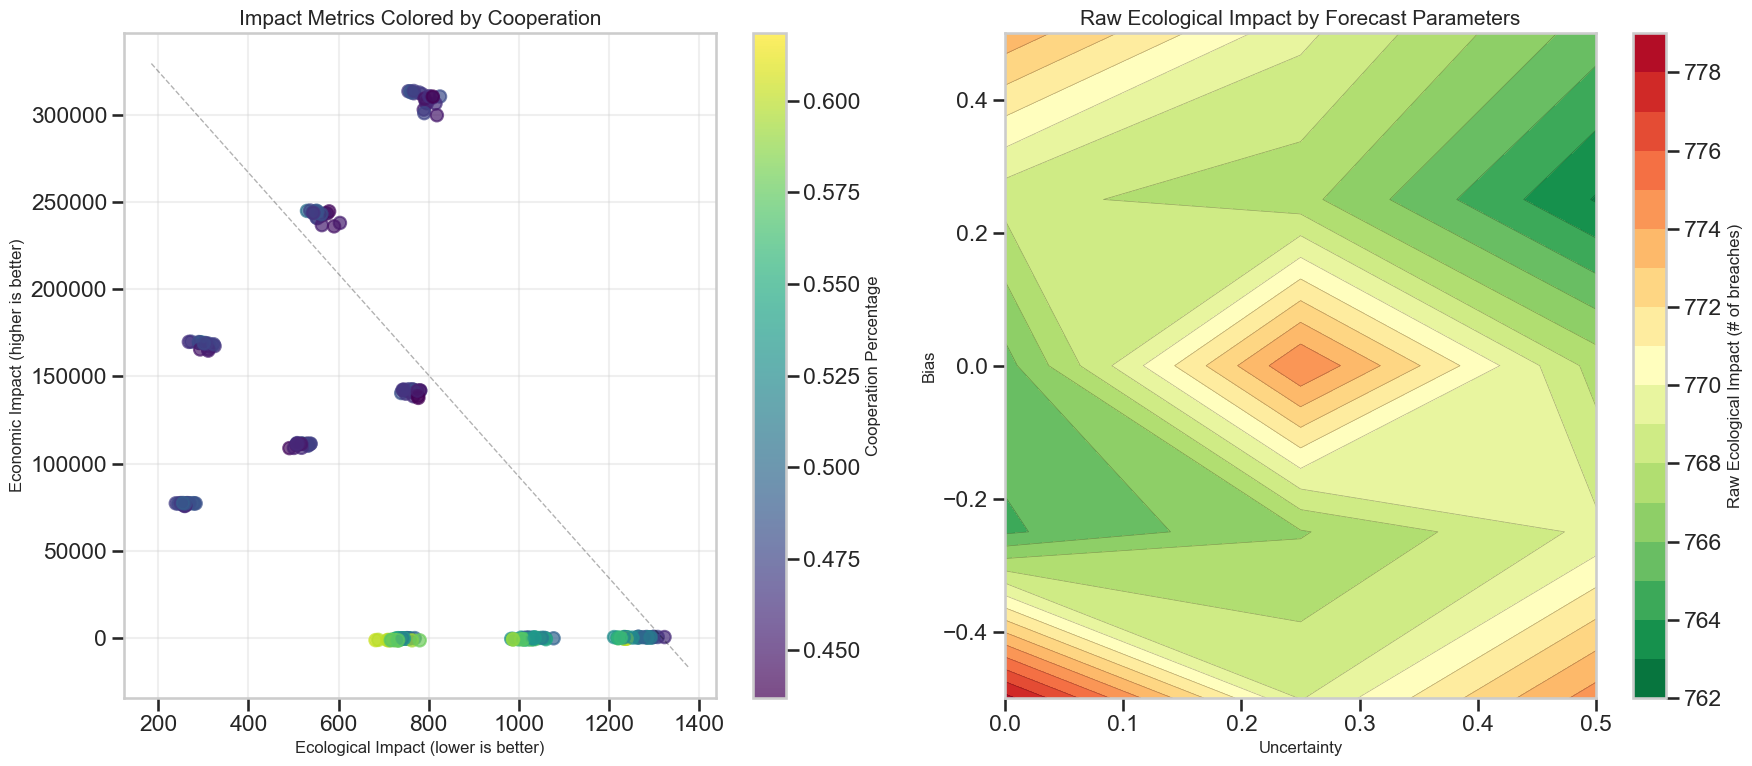

In [14]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!